In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 18034550863826725886, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7469968670997200666
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14890106193419763741
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15884438733
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12543467586605472125
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [3]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, partial, rand, space_eval
from sklearn.metrics import log_loss
import sys
import time
import math
import os
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
# import keras.callbacks as kcall
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
# from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.regularizers import l2, l1

from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score

import matplotlib.pyplot as plt
from keras.layers import Input, concatenate
from keras import optimizers, metrics, models
from keras.layers import Input, Flatten, Dense

%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.13.1


In [5]:
print(os.listdir("../input/full-keras-pretrained-no-top/"))

['densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', 'densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', 'densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5', 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5', 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'nasnet_large_no_top.h5', 'mobilenet_1_0_224_tf_no_top.h5', 'nasnet_mobile_no_top.h5']


In [6]:
batch_size = 512
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
epochs = 1000

In [7]:
train_dir = '../input/icpr2012-augmented/data_augmented/data_augmented/train/'
test_dir = '../input/icpr2012-augmented/data_augmented/data_augmented/test'

In [8]:
def preprocess_input(x):
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    # Zero-center by imagenet mean pixel
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [9]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function = preprocess_input,
    validation_split= 0.2,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 53114 images belonging to 6 classes.
Found 13276 images belonging to 6 classes.
Found 13578 images belonging to 6 classes.


In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 53114
nb_validation_samples: 13276
nb_test_samples: 13578

predict_size_train: 104
predict_size_validation: 26
predict_size_test: 27

 num_classes: 6


In [11]:
os.mkdir("extracted_features")
extracted_features_dir = "extracted_features/"
model_name = "Xception_InceptionV3_augmented_descriptors"

In [12]:
vgg19_weights ="../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_weights ="../input/full-keras-pretrained-no-top//inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg16_weights ="../input/full-keras-pretrained-no-top/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet201_weights ="../input/full-keras-pretrained-no-top/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5"
denseNet121_weights ="../input/full-keras-pretrained-no-top/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5"
resenet50_weights ="../input/full-keras-pretrained-no-top/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
inception_resnet_v2_weights ="../input/full-keras-pretrained-no-top/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
nasnet_weights ="../input/full-keras-pretrained-no-top/nasnet_large_no_top.h5"
nasnet_mobile_weights ="../input/full-keras-pretrained-no-top/nasnet_mobile_no_top.h5"
mobilenet_weights ="../input/full-keras-pretrained-no-top/mobilenet_1_0_224_tf_no_top.h5"
xception_weights = "../input/full-keras-pretrained-no-top/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [13]:
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception, preprocess_input
from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet

In [14]:
input_tensor = Input(shape = input_shape)  

base_model1=InceptionV3(input_shape= input_shape,weights=inception_weights, include_top=False, input_tensor=input_tensor)
base_model2=Xception(input_shape= input_shape,weights=xception_weights, include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

merge = concatenate([x1, x2])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [15]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [16]:
c1 = model.layers[11].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[21].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[28].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[51].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[84].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[103].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[117].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[129].output
c8 = GlobalAveragePooling2D()(c8) 

c9 = model.layers[143].output
c9 = GlobalAveragePooling2D()(c9) 

c10 = model.layers[162].output
c10 = GlobalAveragePooling2D()(c10) 

c11 = model.layers[210].output
c11 = GlobalAveragePooling2D()(c11) 

c12 = model.layers[258].output
c12 = GlobalAveragePooling2D()(c12) 

c13 = model.layers[306].output
c13 = GlobalAveragePooling2D()(c13) 

c14 = model.layers[356].output
c14 = GlobalAveragePooling2D()(c14) 

c15 = model.layers[377].output
c15 = GlobalAveragePooling2D()(c15) 

c16 = model.layers[415].output
c16 = GlobalAveragePooling2D()(c16) 

c17 = model.layers[421].output
c17 = GlobalAveragePooling2D()(c17) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train, max_q_size=1, pickle_safe=False)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [18]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

In [19]:
bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [20]:
import tensorflow as tf
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))

reset_keras_tf_session()

In [21]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [22]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [23]:
# dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(4096, activation="relu", kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6), activity_regularizer=l1(1e-6)))
model.add(Dropout(0.25))

model.add(Dense(1024, activation="relu", kernel_regularizer=l2(1e-6), bias_regularizer=l2(1e-6), activity_regularizer=l1(1e-6)))
model.add(Dropout(0.5))
    
model.add(Dense(num_classes, activation="softmax"))

adam_opt=Adam(lr = 0.0001, beta_1=0.3, beta_2=0.8)

model.compile(optimizer=adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=1000,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
#                     callbacks=[es_callback],
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 53114 samples, validate on 13276 samples
Epoch 1/1000
 - 5s - loss: 0.9472 - acc: 0.7528 - val_loss: 0.7356 - val_acc: 0.7475
Epoch 2/1000
 - 2s - loss: 0.5284 - acc: 0.8566 - val_loss: 0.7859 - val_acc: 0.7413
Epoch 3/1000
 - 2s - loss: 0.4527 - acc: 0.8782 - val_loss: 0.6650 - val_acc: 0.7861
Epoch 4/1000
 - 2s - loss: 0.4137 - acc: 0.8853 - val_loss: 0.6947 - val_acc: 0.7827
Epoch 5/1000
 - 2s - loss: 0.3829 - acc: 0.8951 - val_loss: 0.6612 - val_acc: 0.7885
Epoch 6/1000
 - 2s - loss: 0.3566 - acc: 0.9037 - val_loss: 0.6765 - val_acc: 0.7854
Epoch 7/1000
 - 2s - loss: 0.3412 - acc: 0.9073 - val_loss: 0.5629 - val_acc: 0.8231
Epoch 8/1000
 - 2s - loss: 0.3232 - acc: 0.9121 - val_loss: 0.7024 - val_acc: 0.7926
Epoch 9/1000
 - 2s - loss: 0.3086 - acc: 0.9170 - val_loss: 0.7432 - val_acc: 0.7936
Epoch 10/1000
 - 2s - loss: 0.3014 - acc: 0.9180 - val_loss: 0.5308 - val_acc: 0.8300
Epoch 11/1000
 - 2s - loss: 0.2886 - acc: 0.9216 - val_loss: 0.5984 - val_acc: 0.8115
Epoch 12/1000

Epoch 96/1000
 - 2s - loss: 0.1124 - acc: 0.9695 - val_loss: 0.6114 - val_acc: 0.8404
Epoch 97/1000
 - 2s - loss: 0.1075 - acc: 0.9716 - val_loss: 0.5269 - val_acc: 0.8705
Epoch 98/1000
 - 2s - loss: 0.1055 - acc: 0.9717 - val_loss: 0.6746 - val_acc: 0.8408
Epoch 99/1000
 - 2s - loss: 0.1053 - acc: 0.9710 - val_loss: 0.6144 - val_acc: 0.8475
Epoch 100/1000
 - 2s - loss: 0.1046 - acc: 0.9719 - val_loss: 0.6202 - val_acc: 0.8511
Epoch 101/1000
 - 2s - loss: 0.1061 - acc: 0.9712 - val_loss: 0.6548 - val_acc: 0.8454
Epoch 102/1000
 - 2s - loss: 0.1057 - acc: 0.9715 - val_loss: 0.9006 - val_acc: 0.8506
Epoch 103/1000
 - 2s - loss: 0.1056 - acc: 0.9714 - val_loss: 0.8442 - val_acc: 0.8492
Epoch 104/1000
 - 2s - loss: 0.1047 - acc: 0.9722 - val_loss: 0.7898 - val_acc: 0.8219
Epoch 105/1000
 - 2s - loss: 0.1040 - acc: 0.9727 - val_loss: 0.5318 - val_acc: 0.8769
Epoch 106/1000
 - 2s - loss: 0.1055 - acc: 0.9712 - val_loss: 0.5976 - val_acc: 0.8406
Epoch 107/1000
 - 2s - loss: 0.1043 - acc: 0.97

Epoch 191/1000
 - 2s - loss: 0.0779 - acc: 0.9801 - val_loss: 0.6654 - val_acc: 0.8634
Epoch 192/1000
 - 2s - loss: 0.0780 - acc: 0.9798 - val_loss: 0.7024 - val_acc: 0.8518
Epoch 193/1000
 - 2s - loss: 0.0774 - acc: 0.9803 - val_loss: 0.8535 - val_acc: 0.8339
Epoch 194/1000
 - 2s - loss: 0.0766 - acc: 0.9805 - val_loss: 0.7671 - val_acc: 0.8561
Epoch 195/1000
 - 2s - loss: 0.0776 - acc: 0.9799 - val_loss: 0.7125 - val_acc: 0.8623
Epoch 196/1000
 - 2s - loss: 0.0766 - acc: 0.9801 - val_loss: 0.7588 - val_acc: 0.8366
Epoch 197/1000
 - 2s - loss: 0.0764 - acc: 0.9802 - val_loss: 0.7992 - val_acc: 0.8502
Epoch 198/1000
 - 2s - loss: 0.0773 - acc: 0.9804 - val_loss: 0.8323 - val_acc: 0.8476
Epoch 199/1000
 - 2s - loss: 0.0777 - acc: 0.9800 - val_loss: 0.7897 - val_acc: 0.8367
Epoch 200/1000
 - 2s - loss: 0.0758 - acc: 0.9803 - val_loss: 0.8133 - val_acc: 0.8516
Epoch 201/1000
 - 2s - loss: 0.0745 - acc: 0.9812 - val_loss: 0.7856 - val_acc: 0.8515
Epoch 202/1000
 - 2s - loss: 0.0760 - acc: 

 - 2s - loss: 0.0621 - acc: 0.9846 - val_loss: 0.9219 - val_acc: 0.8458
Epoch 286/1000
 - 2s - loss: 0.0645 - acc: 0.9841 - val_loss: 0.7349 - val_acc: 0.8536
Epoch 287/1000
 - 2s - loss: 0.0635 - acc: 0.9844 - val_loss: 0.8951 - val_acc: 0.8432
Epoch 288/1000
 - 2s - loss: 0.0631 - acc: 0.9845 - val_loss: 0.8497 - val_acc: 0.8466
Epoch 289/1000
 - 2s - loss: 0.0671 - acc: 0.9833 - val_loss: 0.7663 - val_acc: 0.8606
Epoch 290/1000
 - 2s - loss: 0.0627 - acc: 0.9847 - val_loss: 1.0116 - val_acc: 0.8459
Epoch 291/1000
 - 2s - loss: 0.0614 - acc: 0.9847 - val_loss: 0.8285 - val_acc: 0.8499
Epoch 292/1000
 - 2s - loss: 0.0648 - acc: 0.9842 - val_loss: 0.9157 - val_acc: 0.8413
Epoch 293/1000
 - 2s - loss: 0.0626 - acc: 0.9844 - val_loss: 0.9012 - val_acc: 0.8323
Epoch 294/1000
 - 2s - loss: 0.0630 - acc: 0.9842 - val_loss: 0.8829 - val_acc: 0.8417
Epoch 295/1000
 - 2s - loss: 0.0634 - acc: 0.9844 - val_loss: 0.8792 - val_acc: 0.8465
Epoch 296/1000
 - 2s - loss: 0.0618 - acc: 0.9850 - val_lo

Epoch 380/1000
 - 2s - loss: 0.0560 - acc: 0.9868 - val_loss: 0.9454 - val_acc: 0.8508
Epoch 381/1000
 - 2s - loss: 0.0566 - acc: 0.9863 - val_loss: 0.9418 - val_acc: 0.8445
Epoch 382/1000
 - 2s - loss: 0.0587 - acc: 0.9860 - val_loss: 0.9375 - val_acc: 0.8487
Epoch 383/1000
 - 2s - loss: 0.0579 - acc: 0.9856 - val_loss: 0.8017 - val_acc: 0.8475
Epoch 384/1000
 - 2s - loss: 0.0556 - acc: 0.9868 - val_loss: 0.7790 - val_acc: 0.8591
Epoch 385/1000
 - 2s - loss: 0.0569 - acc: 0.9861 - val_loss: 1.0681 - val_acc: 0.8396
Epoch 386/1000
 - 2s - loss: 0.0567 - acc: 0.9862 - val_loss: 0.9354 - val_acc: 0.8457
Epoch 387/1000
 - 2s - loss: 0.0552 - acc: 0.9873 - val_loss: 0.8368 - val_acc: 0.8634
Epoch 388/1000
 - 2s - loss: 0.0564 - acc: 0.9864 - val_loss: 1.0504 - val_acc: 0.8269
Epoch 389/1000
 - 2s - loss: 0.0558 - acc: 0.9863 - val_loss: 0.9624 - val_acc: 0.8487
Epoch 390/1000
 - 2s - loss: 0.0589 - acc: 0.9859 - val_loss: 0.9384 - val_acc: 0.8592
Epoch 391/1000
 - 2s - loss: 0.0562 - acc: 

 - 2s - loss: 0.0517 - acc: 0.9882 - val_loss: 1.0297 - val_acc: 0.8360
Epoch 475/1000
 - 2s - loss: 0.0528 - acc: 0.9878 - val_loss: 0.9379 - val_acc: 0.8497
Epoch 476/1000
 - 2s - loss: 0.0506 - acc: 0.9882 - val_loss: 0.9587 - val_acc: 0.8519
Epoch 477/1000
 - 2s - loss: 0.0523 - acc: 0.9874 - val_loss: 0.9009 - val_acc: 0.8497
Epoch 478/1000
 - 2s - loss: 0.0511 - acc: 0.9880 - val_loss: 0.9456 - val_acc: 0.8533
Epoch 479/1000
 - 2s - loss: 0.0498 - acc: 0.9890 - val_loss: 0.9248 - val_acc: 0.8469
Epoch 480/1000
 - 2s - loss: 0.0523 - acc: 0.9876 - val_loss: 1.0366 - val_acc: 0.8337
Epoch 481/1000
 - 2s - loss: 0.0515 - acc: 0.9874 - val_loss: 1.0522 - val_acc: 0.8293
Epoch 482/1000
 - 2s - loss: 0.0529 - acc: 0.9878 - val_loss: 0.8908 - val_acc: 0.8432
Epoch 483/1000
 - 2s - loss: 0.0523 - acc: 0.9877 - val_loss: 0.9741 - val_acc: 0.8469
Epoch 484/1000
 - 2s - loss: 0.0535 - acc: 0.9871 - val_loss: 0.9973 - val_acc: 0.8418
Epoch 485/1000
 - 2s - loss: 0.0500 - acc: 0.9887 - val_lo

Epoch 569/1000
 - 2s - loss: 0.0488 - acc: 0.9894 - val_loss: 1.1247 - val_acc: 0.8295
Epoch 570/1000
 - 2s - loss: 0.0467 - acc: 0.9895 - val_loss: 0.9080 - val_acc: 0.8588
Epoch 571/1000
 - 2s - loss: 0.0483 - acc: 0.9889 - val_loss: 1.0666 - val_acc: 0.8384
Epoch 572/1000
 - 2s - loss: 0.0489 - acc: 0.9888 - val_loss: 1.0759 - val_acc: 0.8336
Epoch 573/1000
 - 2s - loss: 0.0471 - acc: 0.9891 - val_loss: 0.9775 - val_acc: 0.8373
Epoch 574/1000
 - 2s - loss: 0.0480 - acc: 0.9888 - val_loss: 0.8955 - val_acc: 0.8580
Epoch 575/1000
 - 2s - loss: 0.0493 - acc: 0.9887 - val_loss: 0.9641 - val_acc: 0.8473
Epoch 576/1000
 - 2s - loss: 0.0464 - acc: 0.9893 - val_loss: 0.9757 - val_acc: 0.8520
Epoch 577/1000
 - 2s - loss: 0.0480 - acc: 0.9889 - val_loss: 0.9126 - val_acc: 0.8596
Epoch 578/1000
 - 2s - loss: 0.0473 - acc: 0.9888 - val_loss: 1.0855 - val_acc: 0.8449
Epoch 579/1000
 - 2s - loss: 0.0489 - acc: 0.9886 - val_loss: 0.8533 - val_acc: 0.8588
Epoch 580/1000
 - 2s - loss: 0.0462 - acc: 

 - 2s - loss: 0.0472 - acc: 0.9894 - val_loss: 0.9227 - val_acc: 0.8578
Epoch 664/1000
 - 2s - loss: 0.0479 - acc: 0.9892 - val_loss: 0.8972 - val_acc: 0.8563
Epoch 665/1000
 - 2s - loss: 0.0458 - acc: 0.9898 - val_loss: 1.1098 - val_acc: 0.8464
Epoch 666/1000
 - 2s - loss: 0.0461 - acc: 0.9898 - val_loss: 1.0848 - val_acc: 0.8460
Epoch 667/1000
 - 2s - loss: 0.0459 - acc: 0.9898 - val_loss: 1.1170 - val_acc: 0.8484
Epoch 668/1000
 - 2s - loss: 0.0448 - acc: 0.9898 - val_loss: 1.0932 - val_acc: 0.8423
Epoch 669/1000
 - 2s - loss: 0.0462 - acc: 0.9894 - val_loss: 1.0611 - val_acc: 0.8449
Epoch 670/1000
 - 2s - loss: 0.0435 - acc: 0.9903 - val_loss: 0.9647 - val_acc: 0.8564
Epoch 671/1000
 - 2s - loss: 0.0436 - acc: 0.9899 - val_loss: 1.2156 - val_acc: 0.8256
Epoch 672/1000
 - 2s - loss: 0.0471 - acc: 0.9892 - val_loss: 1.0156 - val_acc: 0.8440
Epoch 673/1000
 - 2s - loss: 0.0454 - acc: 0.9898 - val_loss: 1.0609 - val_acc: 0.8433
Epoch 674/1000
 - 2s - loss: 0.0451 - acc: 0.9900 - val_lo

Epoch 758/1000
 - 2s - loss: 0.0430 - acc: 0.9901 - val_loss: 1.1133 - val_acc: 0.8365
Epoch 759/1000
 - 2s - loss: 0.0438 - acc: 0.9902 - val_loss: 0.9572 - val_acc: 0.8478
Epoch 760/1000
 - 2s - loss: 0.0444 - acc: 0.9904 - val_loss: 1.0871 - val_acc: 0.8539
Epoch 761/1000
 - 2s - loss: 0.0456 - acc: 0.9899 - val_loss: 1.0643 - val_acc: 0.8456
Epoch 762/1000
 - 2s - loss: 0.0450 - acc: 0.9899 - val_loss: 1.0947 - val_acc: 0.8484
Epoch 763/1000
 - 2s - loss: 0.0425 - acc: 0.9906 - val_loss: 0.9853 - val_acc: 0.8531
Epoch 764/1000
 - 2s - loss: 0.0425 - acc: 0.9903 - val_loss: 0.9593 - val_acc: 0.8497
Epoch 765/1000
 - 2s - loss: 0.0444 - acc: 0.9905 - val_loss: 1.0900 - val_acc: 0.8447
Epoch 766/1000
 - 2s - loss: 0.0433 - acc: 0.9908 - val_loss: 1.1209 - val_acc: 0.8393
Epoch 767/1000
 - 2s - loss: 0.0427 - acc: 0.9903 - val_loss: 0.9897 - val_acc: 0.8575
Epoch 768/1000
 - 2s - loss: 0.0443 - acc: 0.9902 - val_loss: 0.9738 - val_acc: 0.8457
Epoch 769/1000
 - 2s - loss: 0.0449 - acc: 

 - 2s - loss: 0.0415 - acc: 0.9911 - val_loss: 1.1207 - val_acc: 0.8523
Epoch 853/1000
 - 2s - loss: 0.0418 - acc: 0.9908 - val_loss: 0.9355 - val_acc: 0.8542
Epoch 854/1000
 - 2s - loss: 0.0415 - acc: 0.9910 - val_loss: 1.0416 - val_acc: 0.8466
Epoch 855/1000
 - 2s - loss: 0.0411 - acc: 0.9912 - val_loss: 1.1507 - val_acc: 0.8415
Epoch 856/1000
 - 2s - loss: 0.0438 - acc: 0.9906 - val_loss: 1.2304 - val_acc: 0.8451
Epoch 857/1000
 - 2s - loss: 0.0411 - acc: 0.9910 - val_loss: 1.1451 - val_acc: 0.8502
Epoch 858/1000
 - 2s - loss: 0.0409 - acc: 0.9909 - val_loss: 1.0103 - val_acc: 0.8410
Epoch 859/1000
 - 2s - loss: 0.0448 - acc: 0.9899 - val_loss: 0.9327 - val_acc: 0.8596
Epoch 860/1000
 - 2s - loss: 0.0430 - acc: 0.9904 - val_loss: 1.1194 - val_acc: 0.8407
Epoch 861/1000
 - 2s - loss: 0.0418 - acc: 0.9908 - val_loss: 1.0268 - val_acc: 0.8462
Epoch 862/1000
 - 2s - loss: 0.0433 - acc: 0.9906 - val_loss: 1.0531 - val_acc: 0.8555
Epoch 863/1000
 - 2s - loss: 0.0420 - acc: 0.9905 - val_lo

Epoch 947/1000
 - 2s - loss: 0.0420 - acc: 0.9908 - val_loss: 1.1064 - val_acc: 0.8506
Epoch 948/1000
 - 2s - loss: 0.0405 - acc: 0.9913 - val_loss: 1.0819 - val_acc: 0.8379
Epoch 949/1000
 - 2s - loss: 0.0422 - acc: 0.9911 - val_loss: 0.9740 - val_acc: 0.8599
Epoch 950/1000
 - 2s - loss: 0.0389 - acc: 0.9920 - val_loss: 0.9923 - val_acc: 0.8544
Epoch 951/1000
 - 2s - loss: 0.0418 - acc: 0.9913 - val_loss: 0.9764 - val_acc: 0.8565
Epoch 952/1000
 - 2s - loss: 0.0419 - acc: 0.9909 - val_loss: 1.0501 - val_acc: 0.8461
Epoch 953/1000
 - 2s - loss: 0.0425 - acc: 0.9903 - val_loss: 1.0096 - val_acc: 0.8488
Epoch 954/1000
 - 2s - loss: 0.0413 - acc: 0.9915 - val_loss: 0.9833 - val_acc: 0.8552
Epoch 955/1000
 - 2s - loss: 0.0410 - acc: 0.9914 - val_loss: 0.9908 - val_acc: 0.8523
Epoch 956/1000
 - 2s - loss: 0.0397 - acc: 0.9918 - val_loss: 1.0810 - val_acc: 0.8441
Epoch 957/1000
 - 2s - loss: 0.0408 - acc: 0.9914 - val_loss: 1.0497 - val_acc: 0.8479
Epoch 958/1000
 - 2s - loss: 0.0401 - acc: 

In [24]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9084548534393873


Confusion Matrix
[[2673    3    9    6   46  189]
 [   2  478    6   18    9    6]
 [   1    6 2754   60   23  235]
 [   0    5   12 1068    8    4]
 [   4   27   53   58 2631   56]
 [  23    9  220   84   61 2731]]


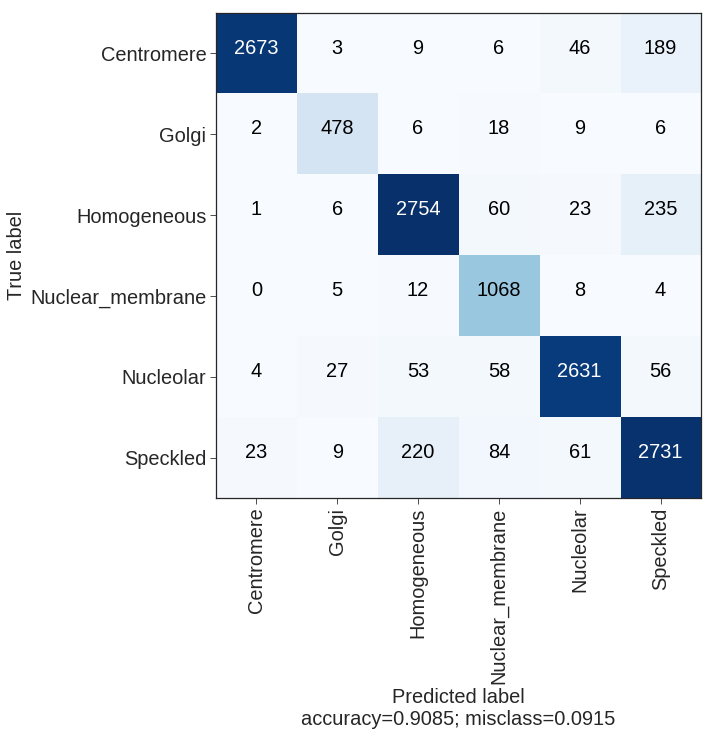

In [32]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[2673    3    9    6   46  189]
 [   2  478    6   18    9    6]
 [   1    6 2754   60   23  235]
 [   0    5   12 1068    8    4]
 [   4   27   53   58 2631   56]
 [  23    9  220   84   61 2731]]
                  precision    recall  f1-score   support

      Centromere       0.99      0.91      0.95      2926
           Golgi       0.91      0.92      0.91       519
     Homogeneous       0.90      0.89      0.90      3079
Nuclear_membrane       0.83      0.97      0.89      1097
       Nucleolar       0.95      0.93      0.94      2829
        Speckled       0.85      0.87      0.86      3128

        accuracy                           0.91     13578
       macro avg       0.90      0.92      0.91     13578
    weighted avg       0.91      0.91      0.91     13578



In [27]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Sensitivity :  0.9992523364485981
Specificity :  0.9937629937629938


In [28]:
y_pred_class = model.predict(test_data, verbose=1)

y_pred_class = [np.argmax(r) for r in y_pred_class]
test_y = [np.argmax(r) for r in test_labels]


from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, roc_curve

# Precision
print('Precision = ', precision_score(test_y, y_pred_class, average='weighted'))
# (None, 'micro', 'macro', 'weighted', 'samples')

# Recall
print('Recall = ', recall_score(test_y, y_pred_class, average='weighted'))

# f1_score
print('f1_score = ', f1_score(test_y, y_pred_class, average='weighted'))

13578/13578 [==============================] - 1s 45us/step
Precision =  0.9115316701200888
Recall =  0.9084548534393873
f1_score =  0.9091135619235827


In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average="weighted"):
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(y_test)

    truth = label_binarizer.transform(y_test)
    pred = label_binarizer.transform(y_pred)
    return roc_auc_score(truth, pred, average=average)
# roc_auc_score
print('roc_auc_score = ', multiclass_roc_auc_score(test_y, y_pred_class))

roc_auc_score =  0.9430537670647474


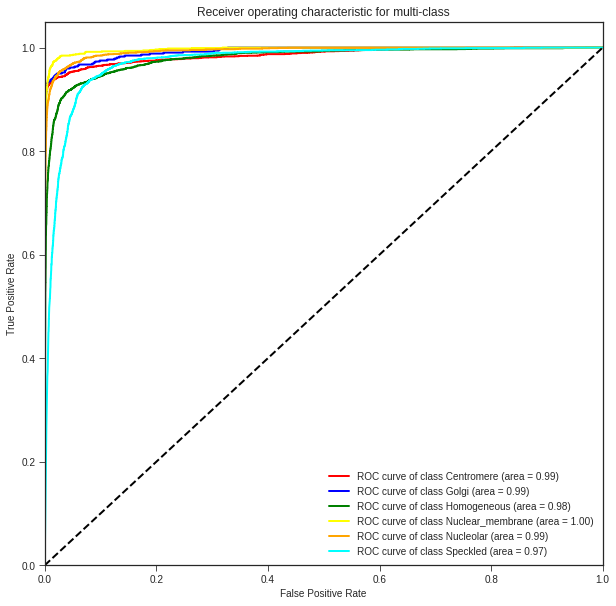

In [33]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle

predict_class = np.argmax(preds, axis=1)

y_pred = preds
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4, 5])
y_pred_binary = y_pred_probabilities
n_classes=6
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

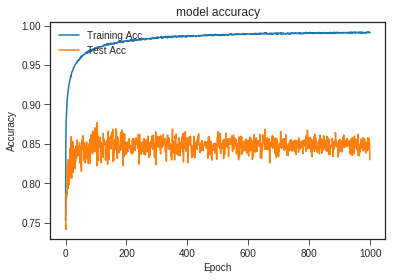

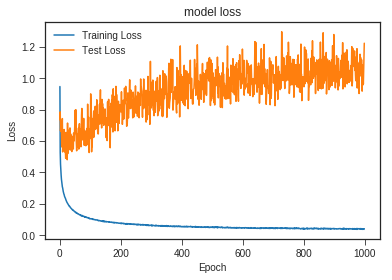

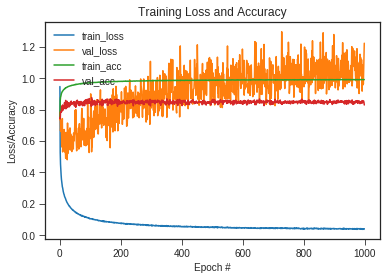

In [31]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")